# Analyzing US Census Salary Data

## The Task
This US Census dataset contains detailed, but anonymized information for approximately 300,000 people.

The archive contains 3 files: 
- A large learning .csv file
- Another test .csv file
- A metadata file describing the columns of the two above mentioned files (identical for both)

The goal of this exercise is to model the information contained in the last column (42nd), i.e., which people make more or less than $50,000 / year, from the information contained in the other columns. The exercise here consists of modeling a binary variable.

Work with R or Python to carry out the following steps:
- Import the learning and text files
- Based on the learning file:
    - Make a quick statistic based and univariate audit of the different columns’ content and produce the results in visual / graphic format. This audit should describe the variable distribution, the % of missing values, the extreme values, and so on.
    - Create a model using these variables (you can use whichever variables you want, or even create you own; for example, you could find the ratio or relationship between different variables, the one-hot encoding of “categorical” variables, etc.) to model wining more or less than $50,000 / year. Here, the idea would be for you to test one or two algorithms, such as logistic regression, or a decision tree. Feel free to choose others if wish.
    - Choose the model that appears to have the highest performance based on a comparison between reality (the 42nd variable) and the model’s prediction. 
    - Apply your model to the test file and measure it’s real performance on it (same method as above).

Find clear insights on the profiles of the people that make more than $50,000 / year. For example, which variables seem to be the most correlated with this phenomenon?

## Import Data
The CSV files don't have any column headers, but this task will be infinitely easier if we label them now. To do so, I will parse the names out of the metadata file from the point where each column is described with its column number using a regular expression to pull out the part between the parenthesis. This happens to only list 41 of the columns; the column we are predicting is missing--which should be index 41--and the "instance_weight" column we are asked to ignore. Once we have the list of column names, we can read in the CSV. 

In [62]:
import re
import pandas as pd

# parse column names from the metadata document
with open('census_income_metadata.txt', 'r') as file:
    metadata = file.readlines()       
col_names = [(re.search('(#\d*\s\()(.*)(?=\))', line).group(2)).replace(' ', '_') for line in metadata if 'distinct values for attribute' in line]  

# add the column we are trying to predict
col_names.append('salary_bucket')

# the task mentions predicting the 42nd column, so let's make sure we have the right length
print('Number of column names parsed: ' + str(len(col_names)))

# since we are a column short, we need to insert the column "instance_weight" which was marked in the metadata to ignore, 
# but we need it to properly label our dataframe
col_names.insert(24, 'instance_weight')

# read in the data and properly label the columns
training_df = pd.read_csv('census_income_learn.csv', header=None, names=col_names)
test_df = pd.read_csv('census_income_test.csv', header=None, names=col_names)

training_df.head()

Number of column names parsed: 41


,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,salary_bucket
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [2]:
test_df.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,salary_bucket
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,...,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
3,35,Private,29,3,High school graduate,0,Not in universe,Divorced,Transportation,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,94,- 50000.
4,49,Private,4,34,High school graduate,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50,95,- 50000.


In [3]:
# see dimensions of data
print(training_df.shape)

# examine data types
print(training_df.dtypes)

# check summary stats about the data
training_df.describe(include='all')

(199523, 42)
age                                             int64
class_of_worker                                object
detailed_industry_recode                        int64
detailed_occupation_recode                      int64
education                                      object
wage_per_hour                                   int64
enroll_in_edu_inst_last_wk                     object
marital_stat                                   object
major_industry_code                            object
major_occupation_code                          object
race                                           object
hispanic_origin                                object
sex                                            object
member_of_a_labor_union                        object
reason_for_unemployment                        object
full_or_part_time_employment_stat              object
capital_gains                                   int64
capital_losses                                  int64
dividends_from_

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,salary_bucket
count,199523.000000,199523,199523.000000,199523.000000,199523,199523.000000,199523,199523,199523,199523,...,199523,199523,199523,199523,199523.000000,199523,199523.000000,199523.000000,199523.000000,199523
unique,NaN,9,NaN,NaN,17,NaN,3,7,24,15,...,43,43,43,5,NaN,3,NaN,NaN,NaN,2
top,NaN,Not in universe,NaN,NaN,High school graduate,NaN,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,NaN,Not in universe,NaN,NaN,NaN,- 50000.
freq,NaN,100245,NaN,NaN,48407,NaN,186943,86485,100684,100684,...,159163,160479,176989,176992,NaN,197539,NaN,NaN,NaN,187141
mean,34.494199,NaN,15.352320,11.306556,NaN,55.426908,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.175438,NaN,1.514833,23.174897,94.499672,NaN
std,22.310895,NaN,18.067129,14.454204,NaN,274.896454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.553694,NaN,0.851473,24.411488,0.500001,NaN
min,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,94.000000,NaN
25%,15.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,0.000000,94.000000,NaN
50%,33.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,8.000000,94.000000,NaN
75%,50.000000,NaN,33.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,52.000000,95.000000,NaN


## Data Prep
To make sure we don't accidentally use that column marked as ignore, we will also drop it before proceeding. Let's also turn the column we are supposed to be predicting into a binary column where less than \$50K will be 0 and more than \$50K will be 1, but let's first check for any strange data that we might hide if we do an if/else beforehand.

In [63]:
# drop the column we are supposed to ignore
training_df = training_df.drop('instance_weight', axis=1)
test_df = test_df.drop('instance_weight', axis=1)

Now before we continue cleaning, let's check that we don't have any missing data. Several columns had '?' as their data, so those should be marked as missing.

In [64]:
import numpy as np

# replace the ? as missing
training_df.replace(to_replace=' ?', value=np.nan, inplace=True)
test_df.replace(to_replace=' ?', value=np.nan, inplace=True)

# check for missing data
print('Missing training data?: ' + str(training_df.isnull().values.any()))
print('Missing training data?: ' + str(test_df.isnull().values.any()))

Missing training data?: True
Missing training data?: True


When we check which columns have missing data and what percentage of it is missing, we see that the migration columns have half of the data missing, so this column is unlikely to be of any use to our model. I would also like to think that where someone or their parents are born has no bearing on their salary, so for the sake of simplifying the model (and since we have all the data in the citizenship column which is a good proxy and something employers will actually know) I won't include these columns. State of previous residence has a very low amount of missing data; we could impute the missing values there to 'Not in universe', but since we aren't entirely sure what that is, we will also ignore that column.

In [4]:
# see percentage of missing data by column
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    missing = series.isnull().sum()
    count = len(series)
    return round(missing/count, 2)

get_percentage_missing(training_df[training_df.columns[training_df.isnull().any()].tolist()])

state_of_previous_residence       0.00
migration_code-change_in_msa      0.50
migration_code-change_in_reg      0.50
migration_code-move_within_reg    0.50
migration_prev_res_in_sunbelt     0.50
country_of_birth_father           0.03
country_of_birth_mother           0.03
country_of_birth_self             0.02
dtype: float64

Let's also look at the percentage of 'not in universe' in the string columns. The metadata doesn't tell us what this really means, so if our model uses this data, we also won't be able to explain this. We see quite a few columns where 50% or more is 'not in universe'; imputing this much data would be dangerous and since we don't really know for sure that this means the data is missing, let's ignore these columns as well.

In [7]:
# see percentage of 'Not in universe' by column
def get_percentage_not_in_universe(series):
    """ Calculates percentage of 'Not in universe' values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    not_in_universe = series.str.contains(pat='not in universe', case=False).sum()
    count = len(series)
    return round(not_in_universe/count, 2)

for col in training_df.select_dtypes(include=[object]).columns.tolist():
    print(str(get_percentage_not_in_universe(training_df[col])) + '\t' + col)

0.5	class_of_worker
0.0	education
0.94	enroll_in_edu_inst_last_wk
0.0	marital_stat
0.5	major_industry_code
0.5	major_occupation_code
0.0	race
0.0	hispanic_origin
0.0	sex
0.9	member_of_a_labor_union
0.97	reason_for_unemployment
0.0	full_or_part_time_employment_stat
0.0	tax_filer_stat
0.92	region_of_previous_residence
0.92	state_of_previous_residence
0.0	detailed_household_and_family_stat
0.0	detailed_household_summary_in_household
0.01	migration_code-change_in_msa
0.01	migration_code-change_in_reg
0.01	migration_code-move_within_reg
0.51	live_in_this_house_1_year_ago
0.42	migration_prev_res_in_sunbelt
0.72	family_members_under_18
0.0	country_of_birth_father
0.0	country_of_birth_mother
0.0	country_of_birth_self
0.0	citizenship
0.99	fill_inc_questionnaire_for_veteran's_admin
0.0	salary_bucket


So let's drop all those columns we aren't going to use based on the above.

In [65]:
cols_to_drop = ['migration_code-change_in_msa',
                'migration_code-change_in_reg',
                'migration_code-move_within_reg',
                'migration_prev_res_in_sunbelt',
                'country_of_birth_father',
                'country_of_birth_mother',
                'country_of_birth_self',
                'fill_inc_questionnaire_for_veteran\'s_admin', 
                'family_members_under_18',
                'state_of_previous_residence',
                'class_of_worker',
                'enroll_in_edu_inst_last_wk',
                'major_industry_code',
                'major_occupation_code',
                'member_of_a_labor_union',
                'reason_for_unemployment',
                'region_of_previous_residence',
                'state_of_previous_residence',
                'live_in_this_house_1_year_ago',
                'family_members_under_18'
               ]

training_df.drop(columns=cols_to_drop, inplace=True)
test_df.drop(columns=cols_to_drop, inplace=True)

In [9]:
# check summary stats about the data
training_df.describe(include='all')

,age,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,marital_stat,race,hispanic_origin,sex,full_or_part_time_employment_stat,...,tax_filer_stat,detailed_household_and_family_stat,detailed_household_summary_in_household,num_persons_worked_for_employer,citizenship,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,salary_bucket
count,199523.000000,199523.000000,199523.000000,199523,199523.000000,199523,199523,199523,199523,199523,...,199523,199523,199523,199523.000000,199523,199523.000000,199523.000000,199523.000000,199523.000000,199523
unique,NaN,NaN,NaN,17,NaN,7,5,10,2,8,...,6,38,8,NaN,5,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,High school graduate,NaN,Never married,White,All other,Female,Children or Armed Forces,...,Nonfiler,Householder,Householder,NaN,Native- Born in the United States,NaN,NaN,NaN,NaN,- 50000.
freq,NaN,NaN,NaN,48407,NaN,86485,167365,171907,103984,123769,...,75094,53248,75475,NaN,176992,NaN,NaN,NaN,NaN,187141
mean,34.494199,15.352320,11.306556,NaN,55.426908,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.956180,NaN,0.175438,1.514833,23.174897,94.499672,NaN
std,22.310895,18.067129,14.454204,NaN,274.896454,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.365126,NaN,0.553694,0.851473,24.411488,0.500001,NaN
min,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,94.000000,NaN
25%,15.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,0.000000,2.000000,0.000000,94.000000,NaN
50%,33.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.000000,NaN,0.000000,2.000000,8.000000,94.000000,NaN
75%,50.000000,33.000000,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.000000,NaN,0.000000,2.000000,52.000000,95.000000,NaN


In [66]:
# make the salary_bucket column a binary
training_df['salary_bucket'] = np.where(training_df['salary_bucket'] == ' - 50000.', 0, 1)
test_df['salary_bucket'] = np.where(test_df['salary_bucket'] == ' - 50000.', 0, 1)
training_df.head()

,age,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,marital_stat,race,hispanic_origin,sex,full_or_part_time_employment_stat,...,tax_filer_stat,detailed_household_and_family_stat,detailed_household_summary_in_household,num_persons_worked_for_employer,citizenship,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,salary_bucket
0,73,0,0,High school graduate,0,Widowed,White,All other,Female,Not in labor force,...,Nonfiler,Other Rel 18+ ever marr not in subfamily,Other relative of householder,0,Native- Born in the United States,0,2,0,95,0
1,58,4,34,Some college but no degree,0,Divorced,White,All other,Male,Children or Armed Forces,...,Head of household,Householder,Householder,1,Native- Born in the United States,0,2,52,94,0
2,18,0,0,10th grade,0,Never married,Asian or Pacific Islander,All other,Female,Not in labor force,...,Nonfiler,Child 18+ never marr Not in a subfamily,Child 18 or older,0,Foreign born- Not a citizen of U S,0,2,0,95,0
3,9,0,0,Children,0,Never married,White,All other,Female,Children or Armed Forces,...,Nonfiler,Child <18 never marr not in subfamily,Child under 18 never married,0,Native- Born in the United States,0,0,0,94,0
4,10,0,0,Children,0,Never married,White,All other,Female,Children or Armed Forces,...,Nonfiler,Child <18 never marr not in subfamily,Child under 18 never married,0,Native- Born in the United States,0,0,0,94,0


In [11]:
# remaining columns
print('REMAINING COLUMNS')
print('\n'.join(training_df.columns.tolist()))

REMAINING COLUMNS
age
detailed_industry_recode
detailed_occupation_recode
education
wage_per_hour
marital_stat
race
hispanic_origin
sex
full_or_part_time_employment_stat
capital_gains
capital_losses
dividends_from_stocks
tax_filer_stat
detailed_household_and_family_stat
detailed_household_summary_in_household
num_persons_worked_for_employer
citizenship
own_business_or_self_employed
veterans_benefits
weeks_worked_in_year
year
salary_bucket


*The metadata states that there are duplicates, but since the file has no unique identifier for each person, we can leave all the rows as is.*

## Exploratory Data Analysis
Ok, now we have gotten rid of a lot of the missing data we can move on to looking at how it is distributed, how the variables are correlated, and see any extreme values.

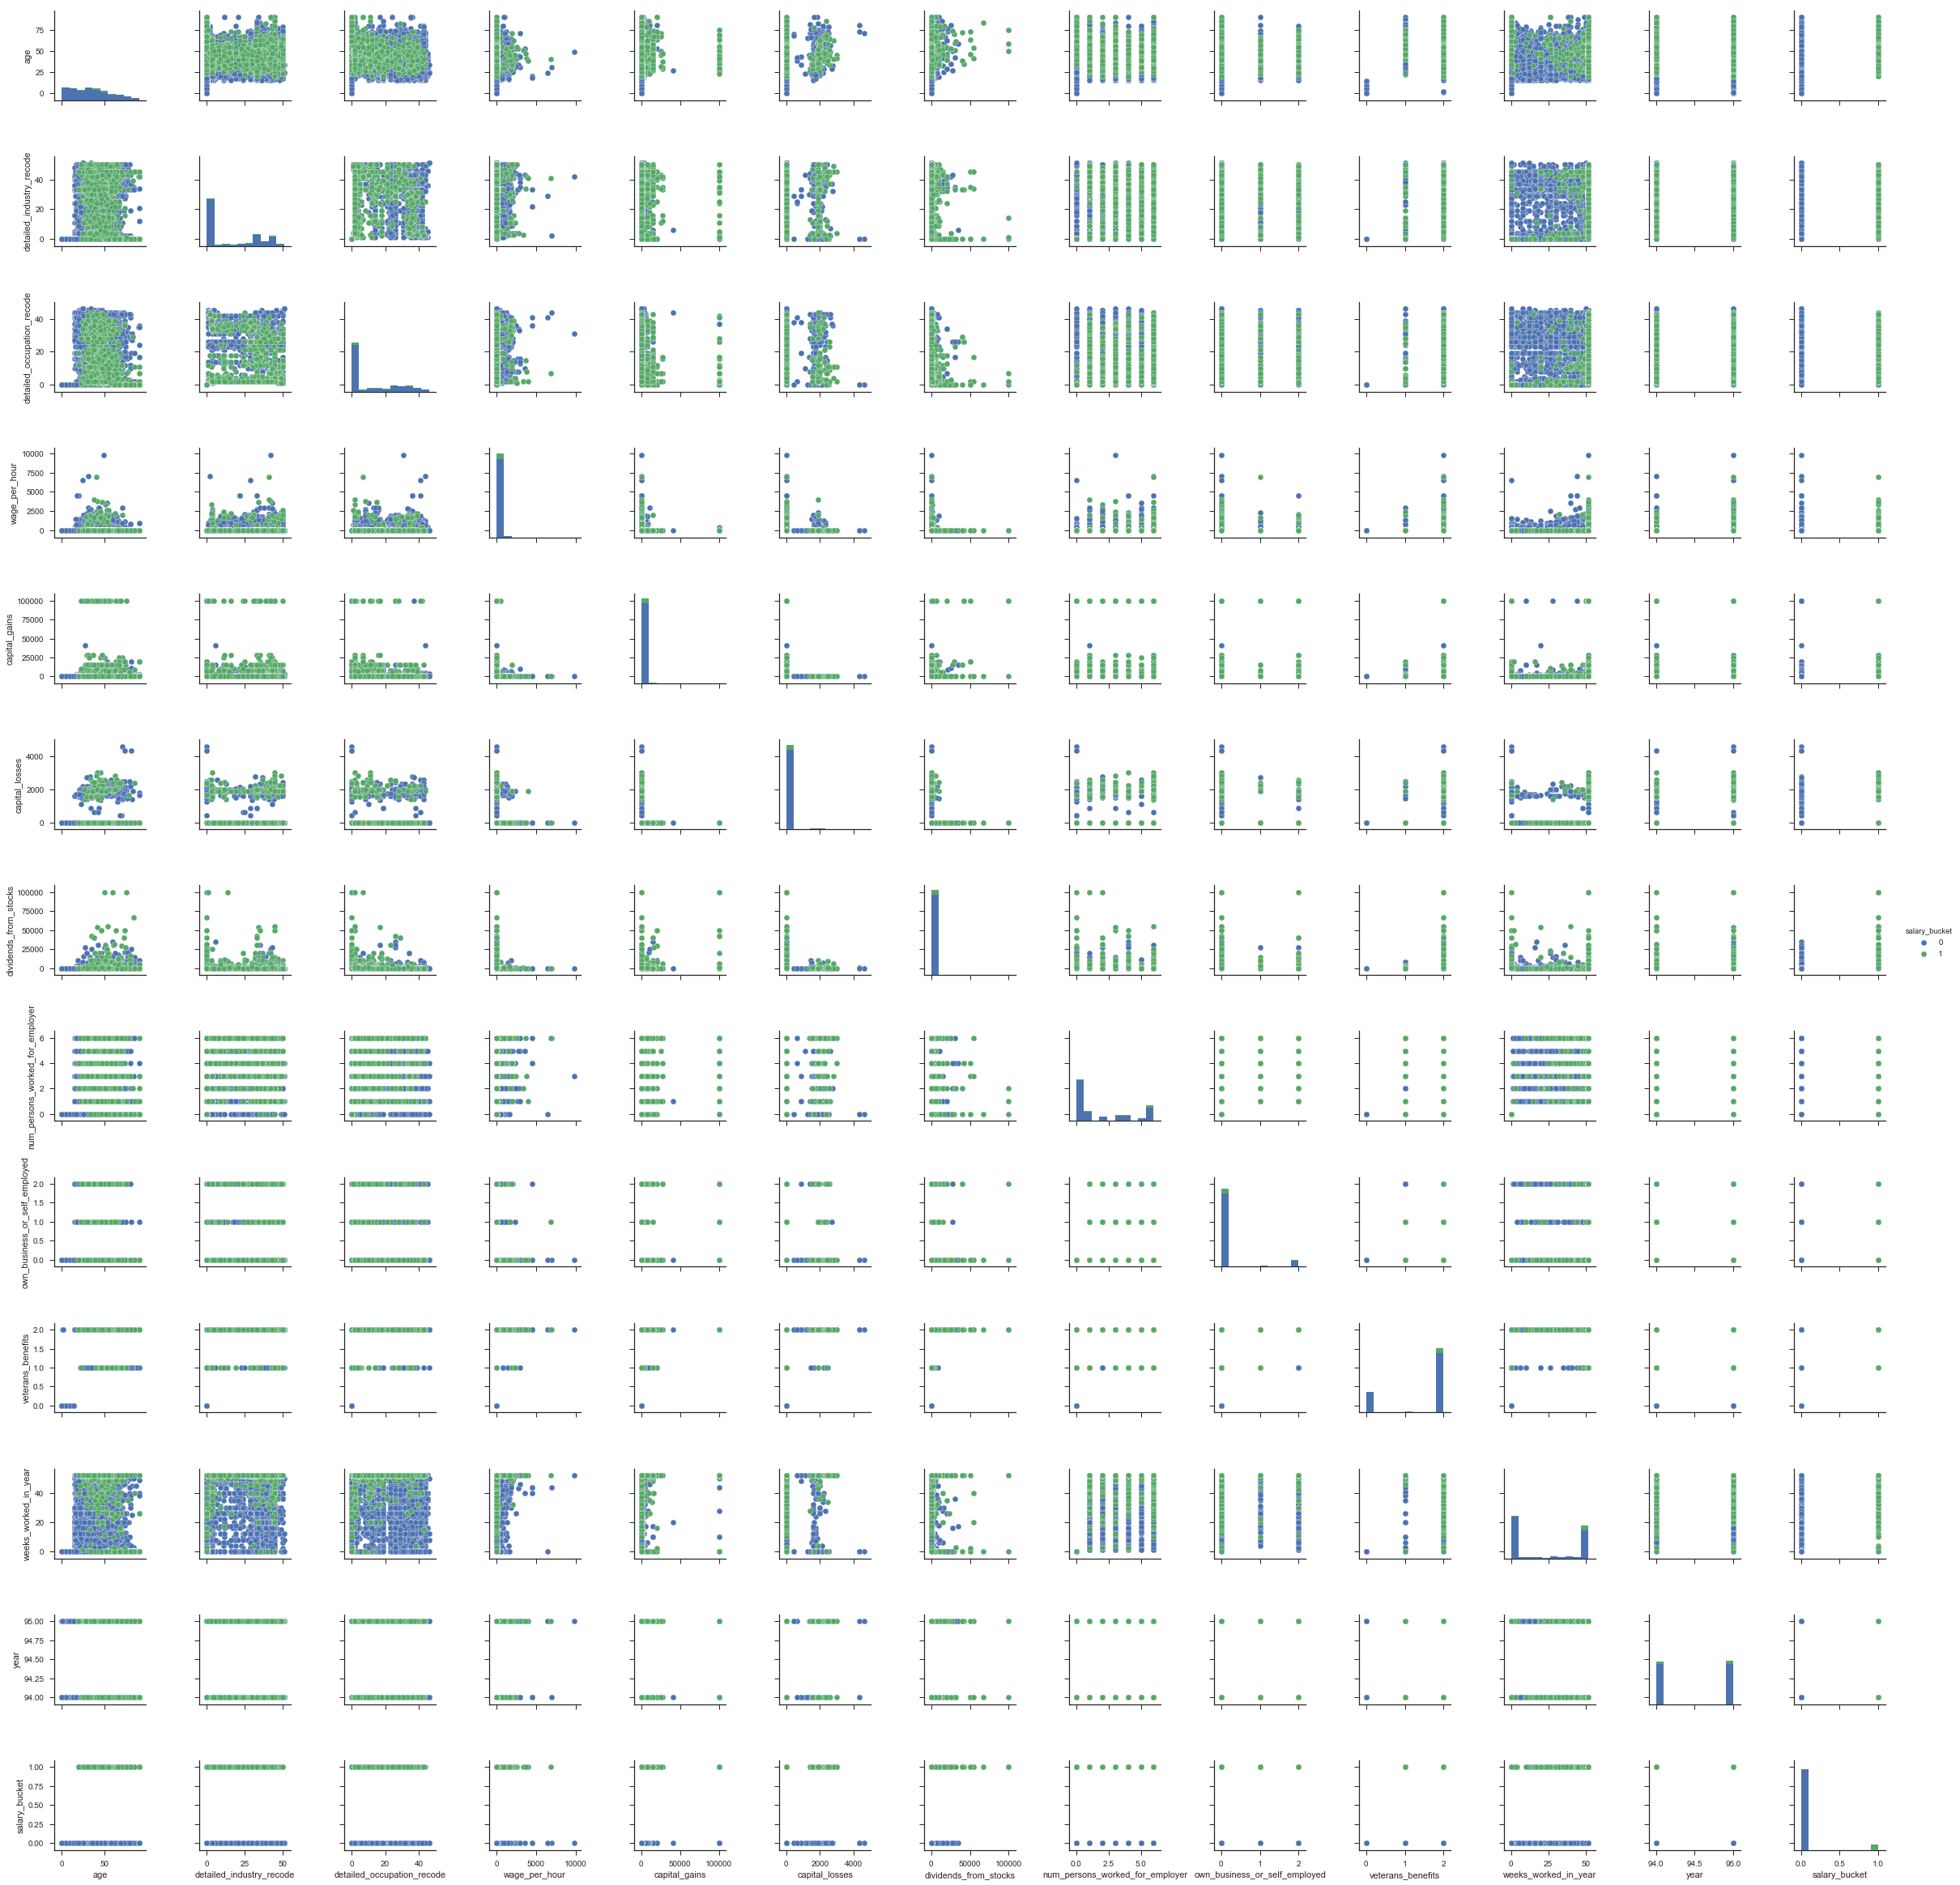

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", color_codes=True)

# relationships of columns
sns.pairplot(training_df.select_dtypes(exclude=[object]).sample(frac=0.1, replace=True), hue='salary_bucket')
plt.show()

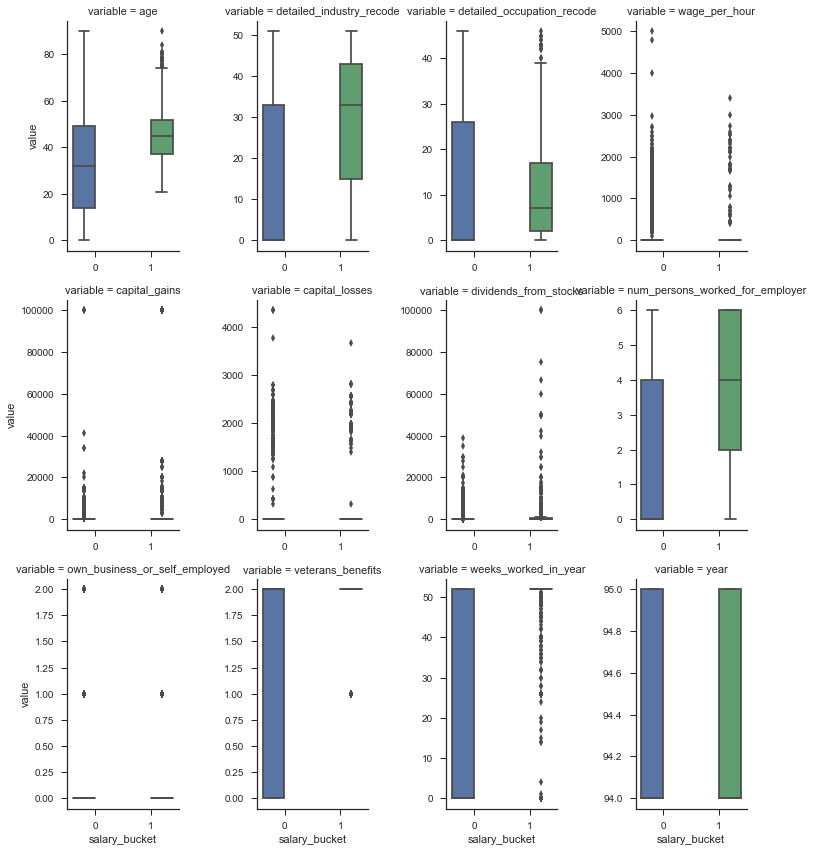

In [26]:
# box plots
sns.factorplot(x='salary_bucket', y='value', hue='salary_bucket', col='variable', kind="box", sharex=False, sharey=False,
               data=pd.melt(training_df.select_dtypes(exclude=[object]).sample(frac=0.1, replace=True), id_vars='salary_bucket'), 
               size=4, aspect=.7, col_wrap=4)
plt.show()

## Feature Engineering
We had some interesting columns in the dataset we were left with, but some of them need some extra prep to be ready for use in a model.

Label Encoding (encode as binary):
- hispanic_origin can be bucketed into a 0, 1 variable for hispanic or not hispanic
- sex

One-hot Encoding:
- race
- education
- marital_stat
- citizenship
- tax_filer_stat
- detailed_household_and_family_stat
- detailed_household_summary_in_household
- own_business_or_self_employed
- veterans_benefits
- full_or_part_time_employment_stat

We will not be using the below since they won't provide us any help in explaining our model (we don't know what they mean):
- detailed_industry_recode
- detailed_occupation_recode

In [67]:
from sklearn.preprocessing import LabelEncoder

# drop the columns we don't know what they mean
unknown_meaning_cols = ['detailed_industry_recode', 'detailed_occupation_recode']

training_df = training_df.drop(columns=unknown_meaning_cols)
test_df = test_df.drop(columns=unknown_meaning_cols)

# binary encoding on sex
sexLabelEncoder = LabelEncoder()
training_df['sex'] = sexLabelEncoder.fit_transform(training_df['sex'])
test_df['sex'] = sexLabelEncoder.transform(test_df['sex'])

# 0 for not hispanic, 1 for hispanic
training_df['hispanic_origin'] = np.where(training_df['hispanic_origin'] == ' All other', 0, 1)
test_df['hispanic_origin'] = np.where(test_df['hispanic_origin'] == ' All other', 0, 1)

# one-hot encode the other categorical variables
one_hot_encode_cols = ['race', 'education', 'marital_stat', 'citizenship', 
                       'tax_filer_stat', 'detailed_household_and_family_stat',
                       'detailed_household_summary_in_household', 'full_or_part_time_employment_stat',
                       'own_business_or_self_employed', 'veterans_benefits']

training_df = pd.get_dummies(training_df, columns=one_hot_encode_cols)
test_df = pd.get_dummies(test_df, columns=one_hot_encode_cols)

## Modelling
This is a classification problem with the 2 classes being more than or less than the $50K mark, and since we have labelled data we can focus on supervised methods. We will evaluate of few machine learning methods for classification tasks. Since the task is to be able to explain the variables that contribute to the salary classification, we won't look into any dimensionality reduction techniques or neural networks which would make the model more of a "black box". For training our model, we will split the data from the training set a little so that we have a validation group, but we will have to be careful that both groups have similar proportions of both classes since they are *very* unevenly split overall.

### Scaling Data

In [68]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['age', 'wage_per_hour', 'capital_gains', 'capital_losses',
                    'weeks_worked_in_year', 'year',
                    'dividends_from_stocks','num_persons_worked_for_employer']

standardScaler = StandardScaler()

training_df[columns_to_scale] = standardScaler.fit_transform(training_df[columns_to_scale])
test_df[columns_to_scale] = standardScaler.fit_transform(test_df[columns_to_scale])

### Training and Validation Data Split

In [69]:
from sklearn.model_selection import train_test_split

# split X and y for test set
X_test = test_df.drop('salary_bucket', axis=1)
y_test = test_df['salary_bucket']

# get train and validation set out of the training data set
X_train, X_validation, y_train, y_validation = train_test_split(training_df.drop('salary_bucket', axis=1),
                                                                training_df['salary_bucket'], random_state=2)

### PCA for Inituition into Decision Boundary

Since we have many dimensions, it's helpful to try to gain intuition of what some possible decision boundaries might look like. Let's use PCA to reduce our data to the 2 component dimensions that explain the largest amount of the variance in our data and plot them. If we see a clear distinction between the salary groups, we would have a good idea of what is a good algorithm to start with.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(2)
trained_PCA = pca.fit_transform(X_train, y_train)

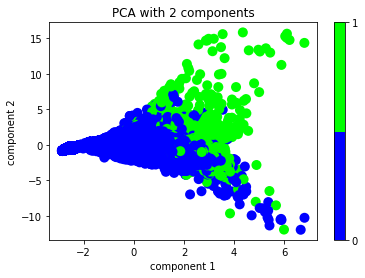

In [25]:
import matplotlib.pyplot as plt

plt.scatter(trained_PCA[:, 0], trained_PCA[:, 1],
            c=y_train, edgecolor='none', alpha=1,
            cmap=plt.cm.get_cmap('brg', 2), s=100)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA with 2 components')
plt.colorbar().set_ticks([0, 1])
plt.show()

There does seem to be some kind of shape, but the groups are very mixed, so we can't get anything from this.

### Baseline Model
Try out Naive Bayes to get a baseline to see if our other models are actually adding value along with their complexity. This is a great starting point because it is very fast and doesn't require parameters; we just have to make the assumption our data is normally distributed--hence the "naive" part.

In [22]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb_model = gnb.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_validation)

In [23]:
print("Number of mislabeled points out of a total %d points : %d" % (X_validation.shape[0],(y_validation != gnb_pred).sum()))

Number of mislabeled points out of a total 49881 points : 24955


In [24]:
from sklearn.metrics import classification_report

def labelled_classification_report(y_true, y_pred):
    return classification_report(y_true, y_pred, target_names=['-50K', '+50K'])

This is better than flipping a coin, but we can definitely improve on this.

In [25]:
print(labelled_classification_report(y_validation, gnb_pred))

             precision    recall  f1-score   support

       -50K       1.00      0.47      0.64     46817
       +50K       0.11      0.99      0.20      3064

avg / total       0.94      0.50      0.61     49881



In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix_visual(y_true, y_pred, data_name):
    mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
    plt.xlabel(data_name)
    plt.ylabel('Model Prediction')
    plt.title('Confusion Matrix -- 1 = +50K')
    plt.show()

We have a very bad ratio of true positives to false positives here, but we nearly find all of the above 50K group.

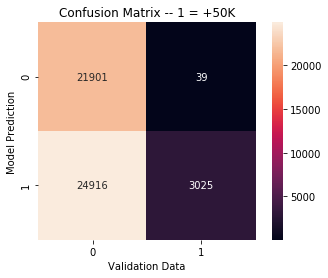

In [27]:
confusion_matrix_visual(y_validation, gnb_pred, 'Validation Data')

### Logistic Regression
Use grid search to find the best parameters; this will run the logistic regression for all combinations of the those parameters and give us the one that performs best.

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logistic_regression = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, 
                                         fit_intercept=True, random_state=42, 
                                         max_iter=100, verbose=0)

parameters = {'C':[1, 0.8, 0.75],
              'penalty' : ['l1', 'l2'],
             'fit_intercept' : [True, False]}

logistic_grid = GridSearchCV(estimator=logistic_regression, param_grid=parameters)

# fit the models to find the best version
logistic_regression_model = logistic_grid.fit(X_train, y_train)
logistic_pred = logistic_regression_model.best_estimator_.predict(X_validation)

print("Number of mislabeled points out of a total %d points : %d" % (X_validation.shape[0],(y_validation != logistic_pred).sum()))

Number of mislabeled points out of a total 49881 points : 2499


(None,)

The model performs great on the below 50K bucket, but we shouldn't get too excited over this because we must keep in mind the huge disparity in the size of the groups (our above 50K bucket is much smaller). Our precision is pretty good for the above 50K group.

In [47]:
print(labelled_classification_report(y_validation, logistic_pred))

             precision    recall  f1-score   support

       -50K       0.96      0.99      0.97     46817
       +50K       0.71      0.31      0.43      3064

avg / total       0.94      0.95      0.94     49881



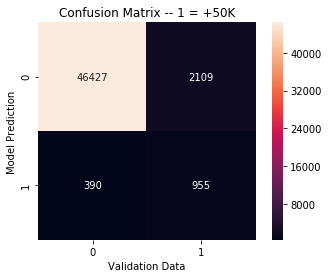

In [48]:
confusion_matrix_visual(y_validation, logistic_pred, 'Validation Data')

We see that our ratio of false positives to true positives is pretty healthy, but let's look at which features are contributing more to this 50K plus classification. Since the logistic regression returns log odds, the coefficients can be thought of as exp(coef) for their effects. Therefore, for the negative coefficients we don't see much effect, however, things like sex, having a PhD or Masters play a huge role.

In [49]:
# Look at coefficients
for feature, coef in zip(X_train.columns, logistic_regression_model.best_estimator_.coef_[0]):
    print(feature + '\t' + str(round(coef, 2)))

age	0.75
wage_per_hour	-0.04
hispanic_origin	-0.4
sex	1.33
capital_gains	0.55
capital_losses	0.16
dividends_from_stocks	0.37
num_persons_worked_for_employer	0.31
weeks_worked_in_year	1.04
year	-0.57
race_ Amer Indian Aleut or Eskimo	-0.63
race_ Asian or Pacific Islander	-0.26
race_ Black	-0.67
race_ Other	-0.27
race_ White	-0.25
education_ 10th grade	-1.19
education_ 11th grade	-1.08
education_ 12th grade no diploma	-0.73
education_ 1st 2nd 3rd or 4th grade	-1.08
education_ 5th or 6th grade	-1.36
education_ 7th and 8th grade	-1.12
education_ 9th grade	-1.15
education_ Associates degree-academic program	0.39
education_ Associates degree-occup /vocational	0.2
education_ Bachelors degree(BA AB BS)	1.12
education_ Children	-0.72
education_ Doctorate degree(PhD EdD)	2.24
education_ High school graduate	-0.35
education_ Less than 1st grade	-1.47
education_ Masters degree(MA MS MEng MEd MSW MBA)	1.58
education_ Prof school degree (MD DDS DVM LLB JD)	2.45
education_ Some college but no degree	

### Decision Tree
Let's see if we can do better with a decision tree.

In [14]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree_trained = tree.fit(X_train, y_train)

tree_pred = tree_trained.predict(X_validation)

print(labelled_classification_report(y_validation, tree_pred))

             precision    recall  f1-score   support

       -50K       0.96      0.96      0.96     46817
       +50K       0.44      0.44      0.44      3064

avg / total       0.93      0.93      0.93     49881



We can see this is worse than the logistic regression, our metrics for the above 50K group have fallen, and we now have more false positives than true positives. We don't want to discard the tree methodology too quickly though since it is very helpful in explaining the model, so we will also look into a random forest classifier.

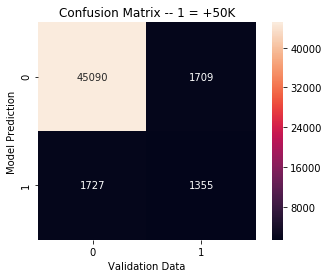

In [15]:
confusion_matrix_visual(y_validation, tree_pred, 'Validation Data')

However, before moving let's look at some of our top features here. We see age and investment activities shining here.

In [44]:
# see feature importances
for feature, importance in zip(X_train.columns, tree_trained.feature_importances_):
    if importance >= 0.01:
        print(feature + '\t' + str(round(importance, 2)))

age	0.17
wage_per_hour	0.02
hispanic_origin	0.01
sex	0.04
capital_gains	0.14
capital_losses	0.03
dividends_from_stocks	0.13
num_persons_worked_for_employer	0.06
weeks_worked_in_year	0.08
year	0.01
education_ Bachelors degree(BA AB BS)	0.02
education_ Doctorate degree(PhD EdD)	0.01
education_ Masters degree(MA MS MEng MEd MSW MBA)	0.02
education_ Prof school degree (MD DDS DVM LLB JD)	0.02
full_or_part_time_employment_stat_ Children or Armed Forces	0.01
full_or_part_time_employment_stat_ Full-time schedules	0.01
own_business_or_self_employed_0	0.01


### Random Forest
Let's see if an ensemble method can improve our performance.

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)
random_forest = forest.fit(X_train, y_train)

forest_pred = random_forest.predict(X_validation)

print(labelled_classification_report(y_validation, forest_pred))

             precision    recall  f1-score   support

       -50K       0.96      0.98      0.97     46817
       +50K       0.60      0.36      0.45      3064

avg / total       0.94      0.95      0.94     49881



Without a doubt this is better than the decision tree, but we have a better precision with the logistic regression, so let's perform the test on the hold out data with that one.

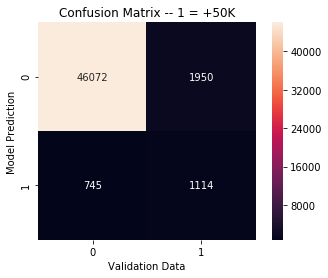

In [18]:
confusion_matrix_visual(y_validation, forest_pred, 'Validation Data')

Quickly looking at feature importances with the random forest, we still see age and investment activities popping out.

In [45]:
# see feature importances
for feature, importance in zip(X_train.columns, random_forest.feature_importances_):
    if importance >= 0.01:
        print(feature + '\t' + str(round(importance, 2)))

age	0.22
wage_per_hour	0.02
sex	0.03
capital_gains	0.09
capital_losses	0.03
dividends_from_stocks	0.13
num_persons_worked_for_employer	0.08
weeks_worked_in_year	0.06
education_ Bachelors degree(BA AB BS)	0.02
education_ Doctorate degree(PhD EdD)	0.02
education_ High school graduate	0.01
education_ Masters degree(MA MS MEng MEd MSW MBA)	0.02
education_ Prof school degree (MD DDS DVM LLB JD)	0.02
tax_filer_stat_ Joint both under 65	0.01
detailed_household_and_family_stat_ Householder	0.01


### ROC Curves
Now that we have a few trained models, let's see which ones give us the largest AUC to move on to testing with our test data.

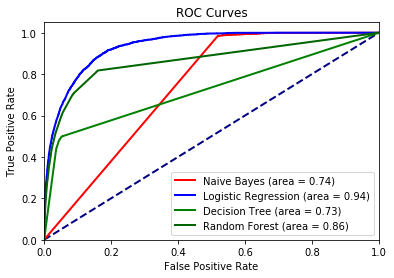

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

nb_prob_fit = gnb_model.predict_proba(X_validation)
log_reg_prob_fit = logistic_regression_model.best_estimator_.predict_proba(X_validation)
tree_prob_fit = tree_trained.predict_proba(X_validation)
forest_prob_fit = random_forest.predict_proba(X_validation)

nb_roc_curve = roc_curve(y_validation, nb_prob_fit[:,1], pos_label=1)
nb_roc_curve_AUC = auc(nb_roc_curve[0], nb_roc_curve[1])
log_reg_roc_curve = roc_curve(y_validation, log_reg_prob_fit[:,1], pos_label=1)
log_reg_roc_curve_AUC = auc(log_reg_roc_curve[0], log_reg_roc_curve[1])
tree_roc_curve = roc_curve(y_validation, tree_prob_fit[:,1], pos_label=1)
tree_roc_curve_AUC = auc(tree_roc_curve[0], tree_roc_curve[1])
forest_roc_curve = roc_curve(y_validation, forest_prob_fit[:,1], pos_label=1)
forest_reg_roc_curve_AUC = auc(forest_roc_curve[0], forest_roc_curve[1])

# plot ROC curves for each method
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')# baseline
plt.plot(nb_roc_curve[0], nb_roc_curve[1],
         color='red', lw=2, label='Naive Bayes (area = %0.2f)' % nb_roc_curve_AUC)
plt.plot(log_reg_roc_curve[0], log_reg_roc_curve[1],
         color='blue', lw=2, label='Logistic Regression (area = %0.2f)' % log_reg_roc_curve_AUC)
plt.plot(tree_roc_curve[0], tree_roc_curve[1],
         color='green', lw=2, label='Decision Tree (area = %0.2f)' % tree_roc_curve_AUC)
plt.plot(forest_roc_curve[0], forest_roc_curve[1],
         color='darkgreen', lw=2, label='Random Forest (area = %0.2f)' % forest_reg_roc_curve_AUC)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

It's close between the logistic regression and the random forest, but the logistic regression wins out.

### Testing the "Best" Model on the Test File
As seen above, we got the best performance out of the logistic regression and the random forest. Let's now test the logistic regression which was the top model on the test data. Note that because the data was given to us separated into test and training sets and our feature engineering one-hot encoded some of the variables, we ended up with one less column in our test set. To correct that, we simply have to add that column with zeroes for everything and we will be able to test our model.

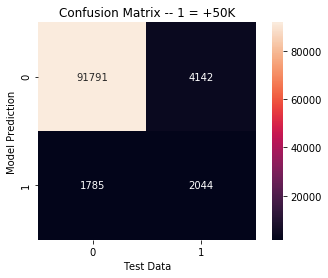

In [71]:
# test logistic regression best estimator against test set
missing_col = [col for col in X_train.columns if col not in X_test.columns]
X_test[missing_col[0]] = 0
y_pred_test_set = logistic_regression_model.best_estimator_.predict(X_test)
confusion_matrix_visual(y_test, y_pred_test_set, 'Test Data')

In [72]:
print(labelled_classification_report(y_test, y_pred_test_set))

             precision    recall  f1-score   support

       -50K       0.96      0.98      0.97     93576
       +50K       0.53      0.33      0.41      6186

avg / total       0.93      0.94      0.93     99762



Our overall performance is pretty good here, although not great at predicting the over 50K bucket. This is because we have a very uneven class distribution with most of our data belonging to the below 50K group. More could be done to improve for the over 50K group such as changing our scoring metrics or engineering new features, but that is beyond the scope of this exercise. 

## Conclusions

By looking at the feature importances of the Random Forest, we can gain some intuition of important variables. The top ones that help to classify salary buckets are age, investment activities (capital gains/losses and dividends), sex, people in the company, wage and weeks worked (as we would expect), and higher education. With the logistic regression we see larger influence from age, sex, investment activities, and higher education again. These are the indicators that we commonly associate with salary: 

- the more educated you are the better your career outlook and the higher your salary
- with age comes more experience with which comes higher salary
- those who invest typically have some money to spare which means they are likely earning more
- sex is a factor even today as we face the pay gap worldwide